In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.power import tt_ind_solve_power 
import matplotlib.pyplot as plt

plt.style.use('dark_background')

Цель исследования - проанализировать результаты A/B теста: определить влияние тестируемых изменений среднюю стоимость заказа пользователя.

Согласно документации к данным структура visitors:

user_id — идинтификатор пользователя;

veriant_name — экспериментальная группа;

revenue — стоимость заказа.

In [2]:
df = pd.read_csv('/Users/aleusandr/AB-test/AB/data/csv/AB_Test_Results.csv')

Проверим целостность данных, присутсвуют ли в них Nan. И соответсвуют ли данные нужным типам.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Проверим грамотность системы сплитования, есть ли у нас такие пользователи, которые находятся и в тестовой и контрольной группе одновременно

In [5]:
user_cont = df[df['VARIANT_NAME'] == 'control']['USER_ID']
user_test = df[df['VARIANT_NAME'] == 'variant']['USER_ID']

print('Количество уникальных юзеров, которые находятся одновременно в двух группах:',
      len(np.intersect1d(user_cont,user_test)))
print('=================================================================================')


Количество уникальных юзеров, которые находятся одновременно в двух группах: 1541


Уберем тех пользователей из датафрейма, которые находятся одновременно в двух группах

In [12]:
df_new = df.loc[~df['USER_ID'].isin(np.intersect1d(user_cont,user_test))]

Контрольная группая имеет тяжелый хвост, посмотрим много ли таких значений

In [13]:
df_new.groupby('VARIANT_NAME', as_index=False).REVENUE.agg({'mean':'mean',
                                                            'stdev':'std',
                                                            'count':'count',
                                                            'max':'max'})

,VARIANT_NAME,mean,stdev,count,max
0,control,0.155506,3.708620,3026,196.01
1,variant,0.058909,0.760344,3044,23.04


В данных присутвует только один выброс, думаю можно от него избавиться

In [14]:
df_new.sort_values('REVENUE', ascending=False).head()

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [15]:
df_without_max = df_new[df_new['REVENUE'] != df_new['REVENUE'].max()]

In [16]:
df_without_max.groupby('VARIANT_NAME', as_index=False).REVENUE.agg({'mean':'mean',
                                                            'stdev':'std',
                                                            'count':'count',
                                                            'max':'max'})

,VARIANT_NAME,mean,stdev,count,max
0,control,0.090760,1.034101,3025,29.32
1,variant,0.058909,0.760344,3044,23.04


<AxesSubplot:xlabel='REVENUE', ylabel='Count'>

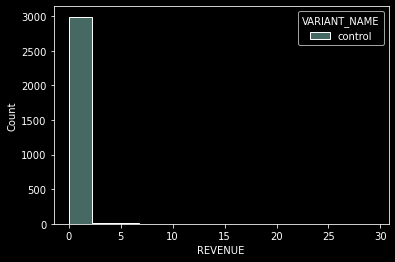

In [17]:
sns.histplot(df_without_max[df_without_max['VARIANT_NAME'] == 'control'], x='REVENUE', hue='VARIANT_NAME')

<AxesSubplot:xlabel='REVENUE', ylabel='Count'>

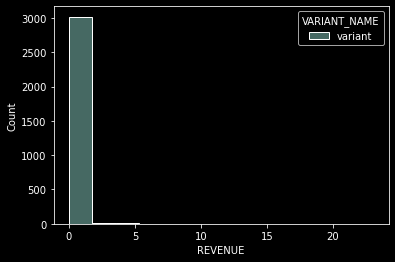

In [18]:
sns.histplot(df_without_max[df_without_max['VARIANT_NAME'] == 'variant'], x='REVENUE', hue='VARIANT_NAME')

Проверим получится ли получить нормальное распредление выборочных средних, если да, то применем т-тест

In [19]:
l = []
n = 1000

for i in range(n):
    l.append(df_without_max[df_without_max['VARIANT_NAME'] == 'control']['REVENUE'].sample(1000, replace=True).mean())

Text(0.5, 1.0, 'Распределение выборочных средних')

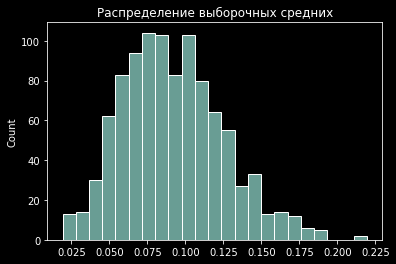

In [20]:
sns.histplot(l)
plt.title('Распределение выборочных средних')

# Проверка статистических гипотез 

H0: различий в средней стоимости заказа в между группами нет

H1: различия в средней стоимости заказа между группами есть

Применем статистический критерий Стьюдента при альфа 0.05

In [60]:
df_without_max.groupby('VARIANT_NAME', as_index=False) \
.agg({'REVENUE':'mean', 'USER_ID':'count'}) \
.rename(columns={'REVENUE':'mean', 'USER_ID':'count_users'})

,VARIANT_NAME,mean,count_users
0,control,0.090760,3025
1,variant,0.058909,3044


In [21]:
res = sm.stats.ttest_ind(df_without_max[df_without_max['VARIANT_NAME'] == 'variant']['REVENUE'], 
                         df_without_max[df_without_max['VARIANT_NAME'] == 'control']['REVENUE'], 
                         usevar="unequal")
print("Two Sample t-test")
print("t =", res[0])
print("p-value =", res[1])
print("df = ", res[2])

Two Sample t-test
t = -1.3663144025815133
p-value = 0.1718956232984357
df =  5553.252812092886


P_value > 0.05, следовательно мы не можем отклонить нулевую гипотезу о равенстве средних

Проверим могли ли мы тут увидеть какие либо различия, посчитаем мощность при имеющеся разнице в средних


In [22]:
mean_control = df_without_max[df_without_max['VARIANT_NAME'] == 'control']['REVENUE'].mean()
mean_test = df_without_max[df_without_max['VARIANT_NAME'] == 'variant']['REVENUE'].mean()

std_control = df_without_max[df_without_max['VARIANT_NAME'] == 'control']['REVENUE'].std()
std_test = df_without_max[df_without_max['VARIANT_NAME'] == 'variant']['REVENUE'].std()

nobs = df_without_max[df_without_max['VARIANT_NAME'] == 'control']['REVENUE'].count()

effect_size = (mean_control - mean_test) / ( (std_control + std_test)/2 )

У нас получилась очень слабая статистическа мощность меньше 80%. Попробуем понять сколько нам нужно данных, чтобы увидеть такие различия, при мощности в 80%

In [23]:
print(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, nobs1=nobs, ratio=1))

0.28151900266960544


In [24]:
print(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, nobs1=None, ratio=1))

12457.317970376882


Чтобы нам задетектировать изменения в 44% нам необходимо в четыре раза больше данных.

# Проверка статистических гипотез ARPU

H0: различий в средней выручки на пользователя между группами нет

H1: различия в средней выручки на пользователя между группами есть

In [27]:
df_arpu = df_without_max.groupby(['VARIANT_NAME', 'USER_ID'], as_index=False).REVENUE.sum()

In [61]:
df_arpu.groupby('VARIANT_NAME', as_index=False) \
.agg({'REVENUE':'mean', 'USER_ID':'count'}) \
.rename(columns={'REVENUE':'mean', 'USER_ID':'count_users'})

,VARIANT_NAME,mean,count_users
0,control,0.114923,2389
1,variant,0.074935,2393


In [32]:
res = sm.stats.ttest_ind(df_arpu[df_arpu['VARIANT_NAME'] == 'variant']['REVENUE'], 
                         df_arpu[df_arpu['VARIANT_NAME'] == 'control']['REVENUE'], 
                         usevar="unequal")
print("Two Sample t-test")
print("t =", res[0])
print("p-value =", res[1])
print("df = ", res[2])

Two Sample t-test
t = -1.3530141605678103
p-value = 0.17612070391611032
df =  4394.71189837828


P_value > 0.05, следовательно мы не можем отклонить нулевую гипотезу о равенстве средней выручки на пользователя 



In [47]:
mean_control = df_arpu[df_arpu['VARIANT_NAME'] == 'control']['REVENUE'].mean()
mean_test = df_arpu[df_arpu['VARIANT_NAME'] == 'variant']['REVENUE'].mean()

std_control = df_arpu[df_arpu['VARIANT_NAME'] == 'control']['REVENUE'].std()
std_test = df_arpu[df_arpu['VARIANT_NAME'] == 'variant']['REVENUE'].std()

nobs = df_arpu[df_arpu['VARIANT_NAME'] == 'control']['REVENUE'].count()

effect_size = (mean_control - mean_test) / ( (std_control + std_test)/2 )

In [48]:
print(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, nobs1=nobs, ratio=1))

0.2772381567608314


In [49]:
print(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, nobs1=None, ratio=1))

10022.541718530958


# Проверка статистических гипотез ARPPU

H0: различий в средней выручки на платящего пользователя между группами нет

H1: различия в средней выручки на платящего пользователя между группами есть

In [36]:
df_arppu = df_arpu[df_arpu['REVENUE'] > 0]

In [62]:
df_arppu.groupby('VARIANT_NAME', as_index=False) \
.agg({'REVENUE':'mean', 'USER_ID':'count'}) \
.rename(columns={'REVENUE':'mean', 'USER_ID':'count_users'})

,VARIANT_NAME,mean,count_users
0,control,5.180189,53
1,variant,4.269524,42


In [42]:
res = sm.stats.ttest_ind(df_arppu[df_arppu['VARIANT_NAME'] == 'variant']['REVENUE'], 
                         df_arppu[df_arppu['VARIANT_NAME'] == 'control']['REVENUE'], 
                         usevar="unequal")
print("Two Sample t-test")
print("t =", res[0])
print("p-value =", res[1])
print("df = ", res[2])

Two Sample t-test
t = -0.8136665690473128
p-value = 0.4179205833376849
df =  92.72209446221731


In [43]:
mean_control = df_arppu[df_arppu['VARIANT_NAME'] == 'control']['REVENUE'].mean()
mean_test = df_arppu[df_arppu['VARIANT_NAME'] == 'variant']['REVENUE'].mean()

std_control = df_arppu[df_arppu['VARIANT_NAME'] == 'control']['REVENUE'].std()
std_test = df_arppu[df_arppu['VARIANT_NAME'] == 'variant']['REVENUE'].std()

nobs = df_arppu[df_arppu['VARIANT_NAME'] == 'control']['REVENUE'].count()

effect_size = (mean_control - mean_test) / ( (std_control + std_test)/2 )

P_value > 0.05, следовательно мы не можем отклонить нулевую гипотезу о равенстве средней выручки на платящего пользователя

У нас получилась очень слабая статистическа мощность меньше 80%. Попробуем понять сколько нам нужно данных, чтобы увидеть такие различия, при мощности в 80%

In [44]:
print(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, nobs1=nobs, ratio=1))

0.13637054357692283


In [45]:
print(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, nobs1=None, ratio=1))

563.7082873609577


# Результаты исследования

1. При проведении анализа были обнаружены ошибки в системе сплитования, так как некоторые пользователи оказались в обоих группах.


2. Задетектировать значимые различия в группах по средней стоимости заказа не получилось, так как p>0.05, следовательно мы не можем отвергуть нулевую гипотезу. Для того, чтобы задетектировать имеющиеся различия, нам необходимо увеличть мощность, текущая мощность равна 28%, чтобы увеличть ее до 80% нам нужно 12457 юзиров на одну ветку, а это в четыре раза больше, чем есть на данный момент. Если бы у меня были исторические данные, я бы попробовал сократить дисперсию методом cuped.


3. Задетектировать значимые различия в группах по средней выручки на пользователя, также не получилось. Мощность очень маленькая 27%


4. Задетектировать значимые различия в группах по средней выручки на платящего пользователя, также не получилось, мощность 13%


Вывод: Я думаю, что можно попробовать подержать эксперемент подольше, чтобы добрать пользователей, что является не очень хорошим решением, или же взять исторические данные и попробоать увеличть чувствительность путем сокращения дисперсии методом cuped